# **Bibliothèques nécessaires**



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines

# **Paramètres de dimension du flex (à modifier)**

In [2]:
l = 40 # mm
R = 2 # mm
h = 0.160 # mm

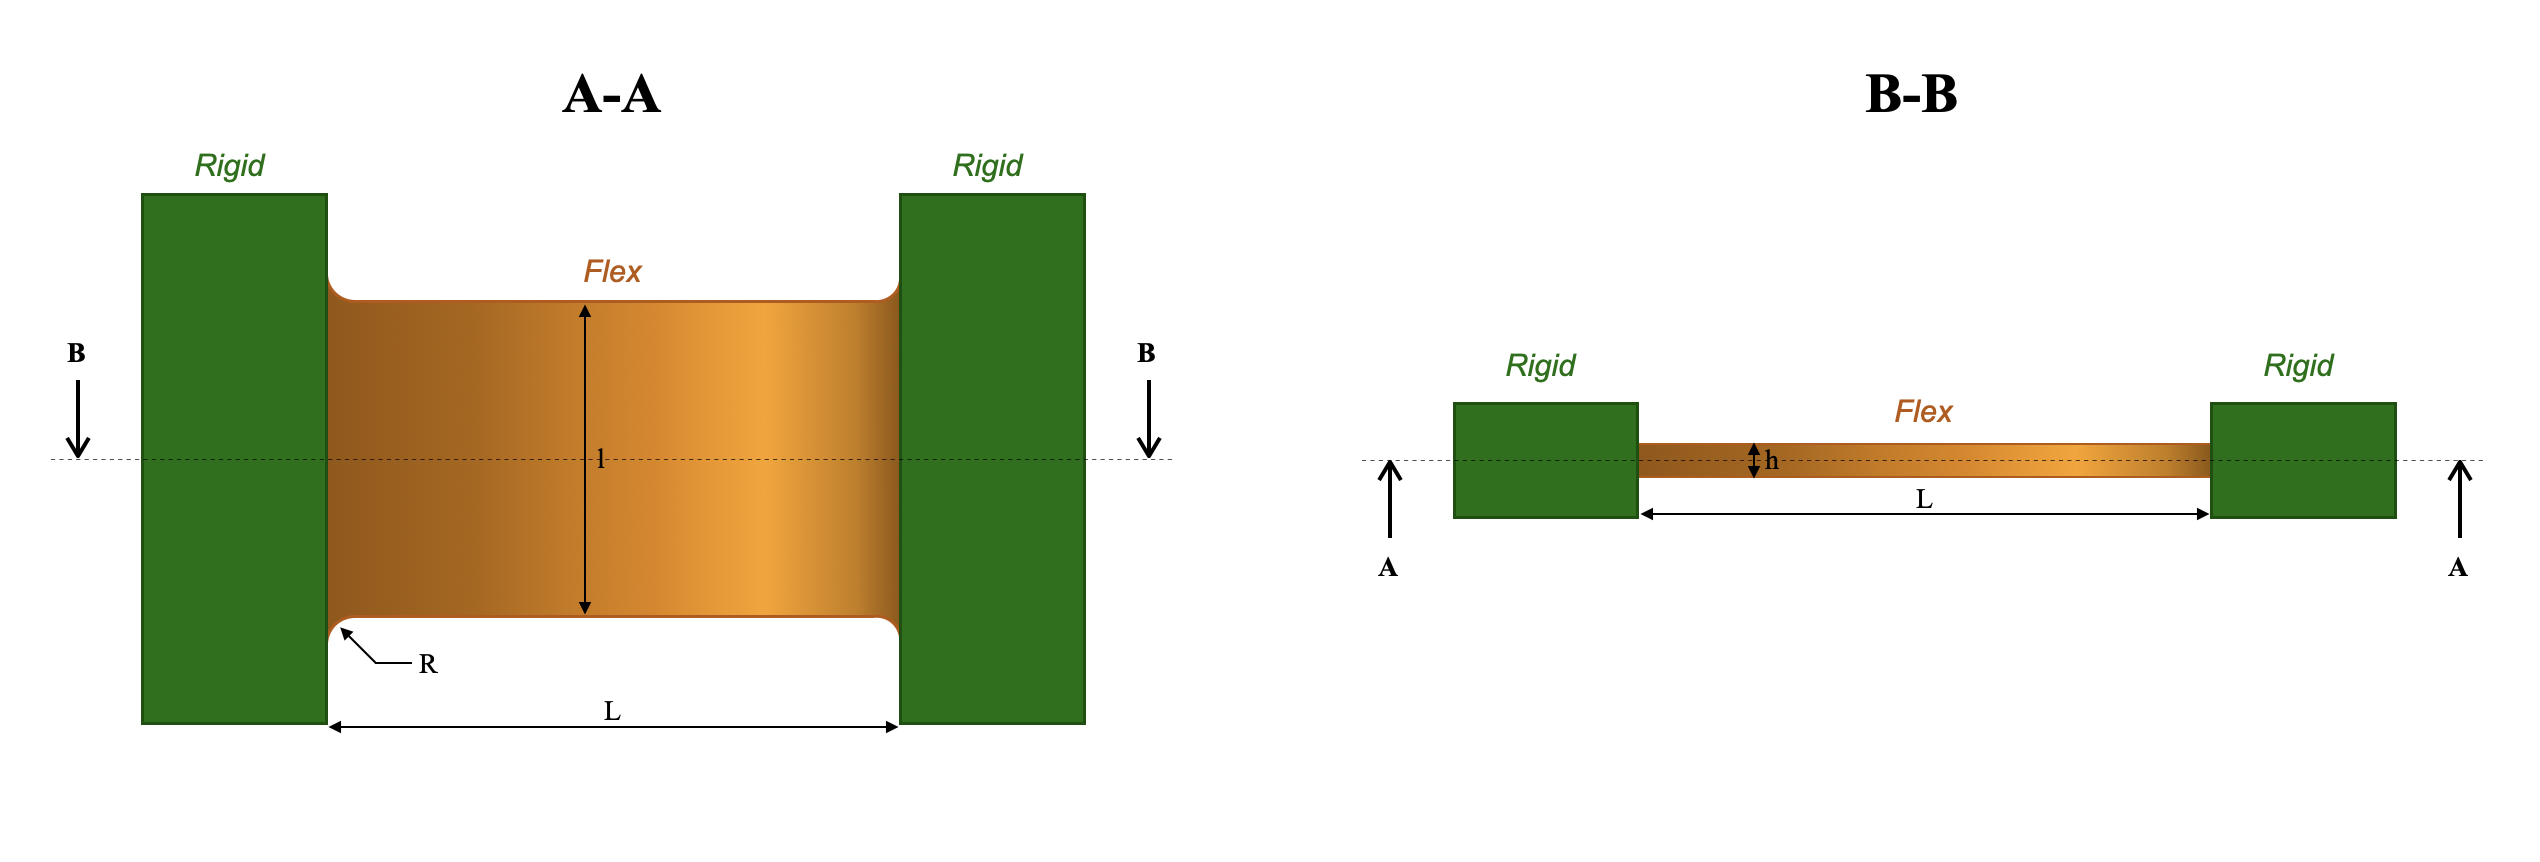

# **Paramètres de calcul (à modifier)**

In [3]:
# Distance D entre le PCB rigide et le connecteur
DISTANCE = 15 # mm

# Longueur L de la nappe du flex
MIN_LENGTH, MAX_LENGTH, STEP_LENGTH = 17, 35, 0.5 # mm <------------ (à modifier)

# Hauteur H du connecteur du flex
MIN_HEIGHT, MAX_HEIGHT, STEP_HEIGHT  = -1, 25, 0.2 # mm <------------ (à modifier)  /!\[Intéressant d'avoir MIN_HEIGHT<0 pour avoir une convergence pour H=0]/!\

# Angle α0 initial du flex par rapport à l'axe Ox
ALPHA_0 = 0 # rad <------------ (à modifier) 

# Angle αf final du flex par rapport à l'axe Ox
ALPHA_F = -np.pi/2 # rad <------------ (à modifier) 

# Guess initial à ne pas trop toucher
INITIAL_GUESS = [0.145942, -0.000444, 0.000107] # [lambda_x, lambda_y, kappa_0] définit plus bas <------------ (à modifier rarement) 


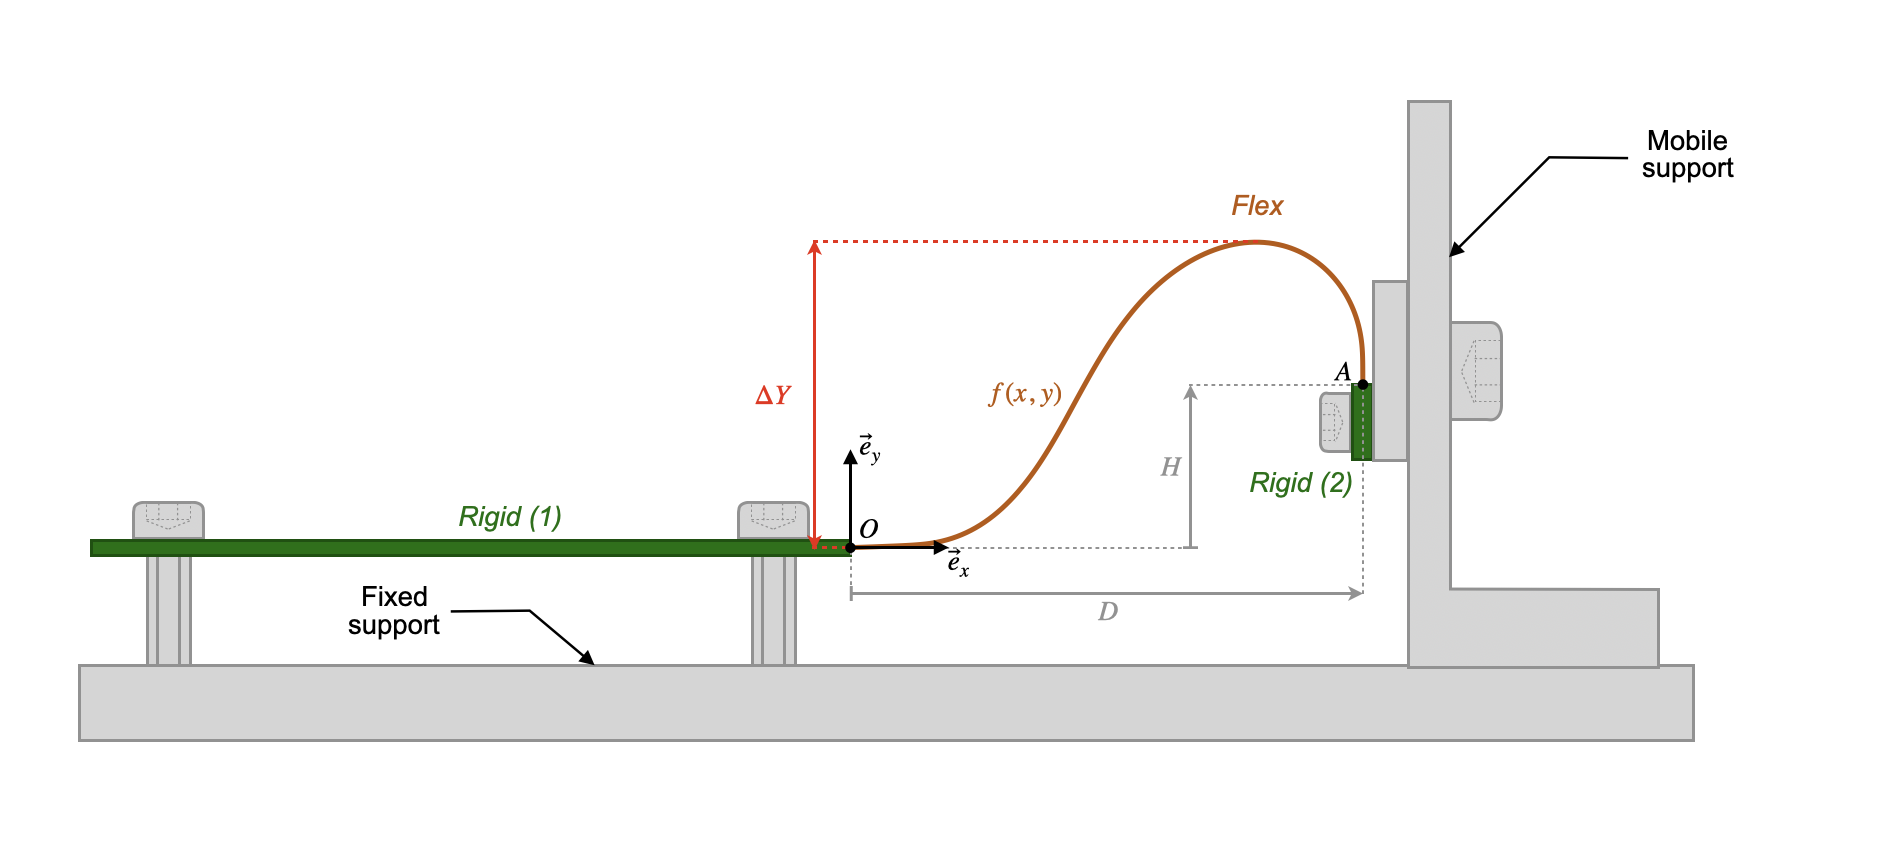

**Vérification des paramètres de calcul (à ne pas modifier)**

In [4]:
# Si MIN_LENGTH est trop petit par rapport à distance on change ou éviter les calculs inutiles
MIN_LENGTH = max(DISTANCE+2,MIN_LENGTH)

# **Paramètres sur les rayons de courbure (à modifier)**

In [5]:
# Rayon de courbure minimal toléré (norme ECSS)
rho_min = max(12*h, 3.2) # mm 

# Ecartement des courbes iso rayon de courbure (iso-rho)
rho_step = 1 # mm

# Rayon de coubure maximal affiché
rho_max = 10 # mm

# Pas de hauteur
H_step = 3 # mm

# **Paramètres d'affichage final (à modifier)**

In [6]:
# Courbe Iso-rho_min
COLOR_ISO_RHO_MIN = 'black'              # <------------ (à modifier)
LINESTYLE_ISO_RHO_MIN = '--'             # <------------ (à modifier)
LINEWIDTH_ISO_RHO_MIN = 0.8              # <------------ (à modifier)

COLOR_RHO_MIN_OPTIMAL = 'red'            # <------------ (à modifier) 

# Courbe Iso-hauteur
COLOR_ISO_H = 'black'                    # <------------ (à modifier)
LINESTYLE_ISO_H = '-'                    # <------------ (à modifier)
LINEWIDTH_ISO_H = 1.5                    # <------------ (à modifier)

# Police d'écriture 
POLICE = 'Times New Roman'               # <------------ (à modifier)

# Couleur de fond 
WALLPAPER = 'white'                      # <------------ (à modifier) 

# Chemin du dossier d'enregistrement
FOLDER= '/Users/prelemartin/Desktop'     # <------------ (à modifier) 

# Type de fichier (pdf ou png)
TYPE_FILE = 'pdf'                        # <------------ (à modifier)

# **Définition du système différentiel de l'élastique**

*   θ'(s)=κ(s)
*   κ'(s) = 1/(EI(s))⋅( λₓ⋅sin(θ(s)) - λᵥ⋅cos(θ(s)) - E⋅I'(s)⋅κ(s) )
*   x'(s) = cos(θ(s))
*   y'(s) = sin(θ(s))





In [7]:
def elastica_odes(s_val, Y, lambda_x, lambda_y, I_func, dI_ds_func):
    theta, kappa, x, y = Y

    # Obtenir les valeurs de I(s) et dI_ds(s) au point actuel
    current_I = I_func(s_val)
    current_dI_ds = dI_ds_func(s_val)

    # Système d'équa diff à résoudre
    dtheta_ds = kappa
    dkappa_ds = (lambda_x * np.sin(theta) - lambda_y * np.cos(theta) - current_dI_ds * kappa) / current_I
    dx_ds = np.cos(theta)
    dy_ds = np.sin(theta)

    return [dtheta_ds, dkappa_ds, dx_ds, dy_ds]

# **Fonction de tir pour trouver les bons multiplicateurs et la courbure initiale**



In [8]:
def shooting_function(params_guess, s_span, initial_conditions_fixed, target_conditions, I_func, dI_ds_func):
    
    # Extraire les estimations initiales pour kappa_0, lambda_x, et lambda_y
    kappa_0_guess, lambda_x_guess, lambda_y_guess = params_guess
    
    # Extraire les conditions initiales fixes pour theta_0, x_0, et y_0
    theta_0_fixed, x_0_fixed, y_0_fixed = initial_conditions_fixed
    
    # Extraire les conditions cibles à s=L pour theta_L, x_L, et y_L
    theta_L_target, x_L_target, y_L_target = target_conditions

    # Combiner les conditions initiales fixes et l'estimation pour kappa_0
    Y0 = [theta_0_fixed, kappa_0_guess, x_0_fixed, y_0_fixed]

    # Résoudre le système d'équations différentielles pour l'élastique
    sol = solve_ivp(
    elastica_odes,
    s_span,
    Y0,
    args=(lambda_x_guess, lambda_y_guess, I_func, dI_ds_func),
    dense_output=True,
    rtol=1e-7,
    atol=1e-9
    )

    # Extraire les valeurs calculées à s=L
    theta_L_computed = sol.y[0, -1]
    x_L_computed = sol.y[2, -1]
    y_L_computed = sol.y[3, -1]

    # Renvoyer la différence entre les conditions calculées et cibles (erreurs à minimiser)
    return [(theta_L_computed - theta_L_target) / np.pi,
            (x_L_computed - x_L_target) / (abs(x_L_target) + 1e-8),
            (y_L_computed - y_L_target) / (abs(y_L_target) + 1e-8)]

**Définition de l'abscisse curviligne**

In [9]:
L_array = np.arange(MIN_LENGTH, MAX_LENGTH+STEP_LENGTH, STEP_LENGTH)
H_array = np.arange(MIN_HEIGHT, MAX_HEIGHT+STEP_LENGTH, STEP_HEIGHT)
reversed_L_array = L_array[::-1] # On inverse L_array pour faciliter la convergence des calculs extrèmes

# **Calculteur**

In [ ]:
# définition des listes utiles
min_radius_matrix = []
DeltaY = []
X_elastica, Y_elastica = [], []

for i, L in tqdm(enumerate(reversed_L_array), total=len(reversed_L_array), desc="Chargement du calcul", position=0):
    s = np.linspace(0, L, 200)
    # definition du moment quadratique I(s)
    b = np.zeros_like(s)
    b[(s >= 2) & (s <= s[-1] - 2)] = l
    X_flex_top = np.zeros_like(s)
    Y_flex_top = np.zeros_like(s)
    for idx in range(len(s)):
        if s[idx] < R:
            y_circ = np.sqrt(R**2 - (s[idx] - R)**2)
            X_flex_top[idx] = s[idx]
            Y_flex_top[idx] = l + 2 * R - y_circ
            b[idx] = l + 2 * (R - y_circ)
        elif s[idx] > s[-1] - R:
            y_circ = np.sqrt(R**2 - ((s[-1] - R) - s[idx])**2)
            X_flex_top[idx] = s[idx]
            Y_flex_top[idx] = l + 2 * R - y_circ
            b[idx] = l + 2 * (R - y_circ)
        else:
            b[idx] = l
            X_flex_top[idx] = s[idx]
            Y_flex_top[idx] = l + R

    # Calcul de I(s) et dI_ds(s)
    I = (b * h**3) / 12
    dI_ds = np.gradient(I, s)
    I_interp = interp1d(s, I, kind='cubic', fill_value="extrapolate")
    dI_ds_interp = interp1d(s, dI_ds, kind='cubic', fill_value="extrapolate")

    X_flex_bot = X_flex_top
    Y_flex_bot = -Y_flex_top + l + 2 * R
    X_flex = np.concatenate((np.zeros(1), X_flex_top, X_flex_bot[::-1]))
    Y_flex = np.concatenate((np.zeros(1), Y_flex_top, Y_flex_bot[::-1]))

    # Conditions initiales et valeurs cibles
    param_opt = []
    L_total = L
    s_span = (0, L_total)
    theta0 = ALPHA_0
    x0 = 0
    y0 = 0
    initial_conditions_fixed = (theta0, x0, y0)
    ny = len(H_array)
    initial_guess_params = INITIAL_GUESS

    min_radius_matrix.append([])
    NRJ.append([])
    DeltaY.append([])
    X_elastica.append([])
    Y_elastica.append([])
    
    for j in range(ny):
        H = H_array[j]
        if L**2 < DISTANCE**2 + H**2:
            min_radius_matrix[-1].append(np.nan)
            DeltaY[-1].append(np.nan)
            X_elastica[-1].append(np.nan)
            Y_elastica[-1].append(np.nan)
            continue

        target_conditions = (ALPHA_F, DISTANCE, H)

        try:
            sol = fsolve(
                shooting_function,
                initial_guess_params,
                args=(s_span, initial_conditions_fixed, target_conditions, I_interp, dI_ds_interp),
                xtol=1e-9,
                factor=0.1,
                full_output=True
            )
            optimal_params, info, ier, msg = sol

            if ier != 1:
                raise RuntimeError("Non convergence")

            kappa0_opt, lambda_x_opt, lambda_y_opt = optimal_params
            Y0_optimal = [theta0, kappa0_opt, x0, y0]

            sol_optimal = solve_ivp(
                elastica_odes,
                s_span,
                Y0_optimal,
                args=(lambda_x_opt, lambda_y_opt, I_interp, dI_ds_interp),
                dense_output=True,
                rtol=1e-9,
                atol=1e-9
            )

            s_model = np.linspace(0, L_total, 200)
            _, kappa_model, x_model, y_model = sol_optimal.sol(s_model)

            with np.errstate(divide='ignore', invalid='ignore'):
                radius = np.where(kappa_model != 0, 1 / np.abs(kappa_model), np.inf)
                min_radius = np.nanmin(radius)

            min_radius_matrix[-1].append(min_radius)
            DeltaY[-1].append(np.max(y_model) - np.min(y_model))
            X_elastica[-1].append(x_model)
            Y_elastica[-1].append(y_model)
            initial_guess_params = [kappa0_opt, lambda_x_opt, lambda_y_opt]

        except Exception as e:
            min_radius_matrix[-1].append(np.nan)
            NRJ[-1].append(np.nan)
            DeltaY[-1].append(np.nan)
            X_elastica[-1].append(np.nan)
            Y_elastica[-1].append(np.nan)
            continue


Chargement du calcul:   8%|█▊                    | 3/37 [01:05<13:16, 23.43s/it]

# **Conversion des listes en tableaux numpy**

In [ ]:
min_radius_matrix = np.array(min_radius_matrix)
DeltaY = np.array(DeltaY)

# **Création des courbes iso-ρ**


In [ ]:
rho_targets = np.unique(np.concatenate(([rho_min], np.arange(rho_step, rho_max + rho_step, rho_step))))
L_crossings = [[] for _ in rho_targets]
H_crossings = [[] for _ in rho_targets]

for i_H, H_val in enumerate(H_array):
    curve = min_radius_matrix[:, i_H]
    for i_L in range(len(reversed_L_array) - 1):
        L1, L2 = reversed_L_array[i_L], reversed_L_array[i_L + 1]
        rho1, rho2 = curve[i_L], curve[i_L + 1]
        for idx_rho, rho_target in enumerate(rho_targets):
            if (rho1 - rho_target) * (rho2 - rho_target) < 0:
                L_interp = L1 + (rho_target - rho1) * (L2 - L1) / (rho2 - rho1)
                L_crossings[idx_rho].append(L_interp)
                H_crossings[idx_rho].append(H_val)

def sort_points_by_proximity(L_list, H_list, factor):
    if len(L_list) <= 1:
        return L_list, H_list

    points = np.column_stack((L_list, H_list)).astype(float)

    # Normalisation des axes L et H
    L_min, L_max = np.min(points[:, 0]), np.max(points[:, 0])
    H_min, H_max = np.min(points[:, 1]), np.max(points[:, 1])

    norm_points = np.column_stack((
        (points[:, 0] - L_min) / (L_max - L_min),
        (points[:, 1] - H_min) / (H_max - H_min)
        ))

    # Calcul de la distance moyenne
    dists_matrix = np.linalg.norm(norm_points[:, None, :] - norm_points[None, :, :], axis=2)
    dists = dists_matrix[np.triu_indices(len(norm_points), k=1)]
    mean_dist = np.mean(dists)
    max_dist = factor * mean_dist

    visited = np.zeros(len(points), dtype=bool)
    sorted_L, sorted_H = [], []

    # Nouveau : démarrer par le point le plus proche de l'origine (0, 0)
    origin = np.array([0, 0])
    dist_to_origin = np.linalg.norm(norm_points - origin, axis=1)
    current_idx = np.argmin(dist_to_origin)

    visited[current_idx] = True
    sorted_L.append(points[current_idx, 0])
    sorted_H.append(points[current_idx, 1])

    for _ in range(1, len(points)):
        current_point = norm_points[current_idx]
        dists = np.linalg.norm(norm_points - current_point, axis=1)
        dists[visited] = np.inf
        next_idx = np.argmin(dists)
        if dists[next_idx] > max_dist:
            break
        visited[next_idx] = True
        sorted_L.append(points[next_idx, 0])
        sorted_H.append(points[next_idx, 1])
        current_idx = next_idx

    return sorted_L, sorted_H

L_crossings_sorted = []
H_crossings_sorted = []

for Ls, Hs in zip(L_crossings, H_crossings):
    sorted_L, sorted_H = sort_points_by_proximity(Ls, Hs, factor=4)
    L_crossings_sorted.append(sorted_L)
    H_crossings_sorted.append(sorted_H)


# **Affichage final**

In [ ]:
interp_DeltaY = []

for i in range(len(H_array)):
    interp_fun = interp1d(reversed_L_array, DeltaY[:, i], kind='linear', bounds_error=False, fill_value=np.nan)
    interp_DeltaY.append(interp_fun)


In [ ]:
# Changer la police 
mpl.rcParams['font.family'] = POLICE
idx_H_pos = np.where(H_array >= 0)[0]

R_target_plot = rho_min

fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
ax.set_facecolor(WALLPAPER)

# --- Tracé des iso-H ---
H_targets = np.arange(0, np.max(H_array) + H_step, H_step)
for H_target in H_targets:
    idx = np.argmin(np.abs(H_array - H_target))
    H_val = H_array[idx]

    # tracer la courbe
    plt.plot(reversed_L_array, DeltaY[:, idx],
             linestyle=LINESTYLE_ISO_H, color=COLOR_ISO_H,
             linewidth=LINEWIDTH_ISO_H, alpha=0.7)

    # ajouter une étiquette sur la fin de courbe
    for j in reversed(range(len(reversed_L_array))):
        if np.isfinite(DeltaY[j, idx]):
            x_annot = reversed_L_array[j]
            y_annot = DeltaY[j, idx]
            plt.text(x_annot, y_annot, f'{H_val:.1f}',
                     fontsize=6, color=COLOR_ISO_H,
                     va='center', ha='right')
            break

# --- Tracé des iso-rho_min ---
for i, R_target in enumerate(rho_targets):
    L_vals = np.array(L_crossings_sorted[i])
    H_vals = np.array(H_crossings_sorted[i])
    mask = H_vals > 0
    L_vals_pos = L_vals[mask]
    H_vals_pos = H_vals[mask]
    DeltaY_vals = []
    for L, H in zip(L_vals_pos, H_vals_pos):
        idx_H_closest = np.argmin(np.abs(H_array - H))
        deltaY_val = interp_DeltaY[idx_H_closest](L)
        DeltaY_vals.append(deltaY_val)

    if len(L_vals_pos) == 0:
        continue
    color = COLOR_RHO_MIN_OPTIMAL if R_target == rho_min else COLOR_ISO_RHO_MIN
    size_police = 10 if R_target == rho_min else 6
    linewidth = 1.5 if R_target == rho_min else LINEWIDTH_ISO_RHO_MIN
    
    plt.plot(L_vals_pos, DeltaY_vals,
             LINESTYLE_ISO_RHO_MIN, color=color,
             linewidth=linewidth, alpha=0.7)

    # annotation sur la fin de la courbe
    if np.isfinite(L_vals_pos[-1]) and np.isfinite(DeltaY_vals[-1]):
        plt.text(L_vals_pos[-1], DeltaY_vals[-1],
                 f'{R_target:.1f}',
                 fontsize=size_police, color=color,
                 va='bottom', ha='right')


# --- Mise en forme du titre ---
ax.text(0.5, 0.93, f"Distance = {DISTANCE} mm",
        transform=ax.transAxes,
        fontsize=12,
        fontweight='normal',
        ha='center',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha=0.9))

isoH_line = mlines.Line2D([], [], linestyle=LINESTYLE_ISO_H, color=COLOR_ISO_H,
                          linewidth=LINEWIDTH_ISO_H, label='iso-H (mm)')
isoRho_line = mlines.Line2D([], [], linestyle=LINESTYLE_ISO_RHO_MIN, color=COLOR_ISO_RHO_MIN,
                            linewidth=LINEWIDTH_ISO_RHO_MIN, label=r'iso-$\rho_{\min}$ (mm)')

# Ajouter la légende en dessous
ax.legend(handles=[isoH_line, isoRho_line],
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=False, ncol=2)

plt.xlabel('L (mm)')
plt.ylabel('ΔY (mm)')
plt.grid(True, alpha=0.2)
plt.xlim(DISTANCE, 35)
plt.ylim(0, 30)
plt.tight_layout()
plt.savefig(FOLDER+f'Abaque_1.'+TYPE_FILE)
plt.show()